# Case_study_7_3

Implement the LASSO algorithm using distributed ADMM. In this case, ADMM looks like:
$$
{\bf{w}}_{i,k+1}=\underset{{\bf{w}}_{i}}{\arg\min}\left(\frac{1}{n}\left\Vert {\bf{X}}_{i}{\bf{w}}_{i}-{\bf{y}}_{i}\right\Vert _{2}^{2}+\frac{\rho}{2}\left\Vert {\bf{w}}_{i}-{\bf{z}}_{k}+{\bf{u}}_{i,k}\right\Vert _{2}^{2}\right)\\
{\bf{z}}_{k+1}=\textrm{Soft}\left(\bar{{\bf{w}}}_{k+1}+\bar{{\bf{u}}}_{k},\lambda/\rho n\right)\\
{\bf{u}}_{i,k+1}={\bf{u}}_{i,k}+{\bf{w}}_{i,k+1}-{\bf{z}}_{k+1}
$$
The ${\bf{w}}-$update is very simple in this case:
$$
{\bf{w}}_{i,k+1}=\left(\frac{2}{n}{\bf{X}}_{i}^{T}{\bf{X}}_{i}+\rho I\right)^{-1}\left(\frac{2}{n}{\bf{X}}_{i}^{T}{\bf{y}}_{i}+\rho\left({\bf{z}}_{k}-{\bf{u}}_{i,k}\right)\right)
$$

In [ ]:
!wget --no-cache -O init.py -q https://raw.githubusercontent.com/jdariasl/OTBD/main/content/init.py
import init; init.init(force_download=False)

In [1]:
from local.lib.Generation import scenarios_regression
from local.lib.utils import solver_cvx, grad_FOM, grad_SOM, grad_FOM_decay, admm_lasso, admm_lasso_dist, ista_lasso, fista_lasso, eval_loss, plot_surface
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
#!pip install cvxpy

In [ ]:
import cvxpy as cp

In [2]:
# Loading scenarios
# ===========================
scenario=2
data_class, set_up =scenarios_regression(scenario)


# Definition of the problem
#===================================
loss_fn = lambda n, X, Y, w: (1/n)*cp.pnorm(X @ w - Y, p=2)**2
reg_L1 = lambda w: cp.pnorm(w, p=1)
loss_lasso = lambda n, X, Y, w, lambd: loss_fn(n, X, Y, w) + lambd * reg_L1(w)

subgrad_lasso = lambda n, X, Y, w, lambd: (2/n)*X.T@(X@w-Y)+lambd*np.sign(w)
grad_LS = lambda n, X, Y, w, lambd: (2/n)*X.T@(X@w-Y);


# Solution of the empirical risk using CVX
#=========================================
w_lasso_cvx=solver_cvx(set_up,loss_lasso)

w = cp.Variable(w_lasso_cvx.shape[0])
w.value = w_lasso_cvx 
loss_opt=loss_lasso(set_up['Niter_train'],set_up['Xtrain'][:,:set_up['d']+1],set_up['ytrain'][:,0],w,set_up['Lambda']).value

# Gradient descent
out_subgd =grad_FOM(set_up,subgrad_lasso)
out_subgd_decay =grad_FOM_decay(set_up,subgrad_lasso)

loss_subgrad=eval_loss(out_subgd,set_up,loss_lasso)
loss_subgrad_decay=eval_loss(out_subgd_decay,set_up,loss_lasso)

out_ista=ista_lasso(set_up,grad_LS)
out_fista=fista_lasso(set_up,grad_LS)

loss_ista=eval_loss(out_ista,set_up,loss_lasso)
loss_fista=eval_loss(out_fista,set_up,loss_lasso)

# ADMM algorithm
out_admm =admm_lasso(set_up);
loss_admm=eval_loss(out_admm,set_up,loss_lasso)

# Distributed ADMM algorithm
out_admm_dist = admm_lasso_dist(set_up);
out_admm_dist2=np.c_[out_admm_dist[:,:int(set_up['Niter_train']/set_up['Number_nodes'])], np.kron(out_admm_dist[:,int(set_up['Niter_train']/set_up['Number_nodes'])].reshape(-1,1),np.ones((1,set_up['Niter_train']-int(set_up['Niter_train']/set_up['Number_nodes']))))]
loss_admm_dist=eval_loss(out_admm_dist2,set_up,loss_lasso)


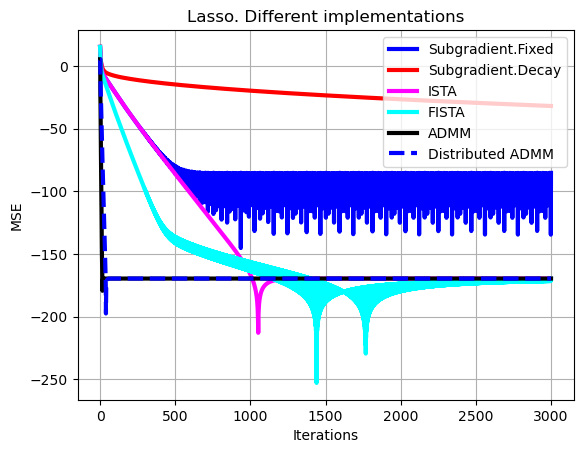

In [3]:
# Plot of learning curves
plt.plot(np.arange(0,set_up['Niter_train']),10*np.log10(np.sum((loss_subgrad-loss_opt*np.ones((1,set_up['Niter_train'])))**2,axis=0)),color='b', linewidth = 3, label = 'Subgradient.Fixed')
plt.plot(np.arange(0,set_up['Niter_train']),10*np.log10(np.sum((loss_subgrad_decay-loss_opt*np.ones((1,set_up['Niter_train'])))**2,axis=0)),color='r', linewidth = 3, label = 'Subgradient.Decay')
plt.plot(np.arange(0,set_up['Niter_train']),10*np.log10(np.sum((loss_ista-loss_opt*np.ones((1,set_up['Niter_train'])))**2,axis=0)),color='magenta', linewidth = 3, label = 'ISTA'),
plt.plot(np.arange(0,set_up['Niter_train']),10*np.log10(np.sum((loss_fista-loss_opt*np.ones((1,set_up['Niter_train'])))**2,axis=0)),color='cyan', linewidth = 3, label = 'FISTA')
plt.plot(np.arange(0,set_up['Niter_train']),10*np.log10(np.sum((loss_admm-loss_opt*np.ones((1,set_up['Niter_train'])))**2,axis=0)),color='black', linewidth = 3, label = 'ADMM')
plt.plot(np.arange(0,set_up['Niter_train']),10*np.log10(np.sum((loss_admm_dist-loss_opt*np.ones((1,set_up['Niter_train'])))**2,axis=0)),color='b', linestyle='dashed',linewidth = 3, label = 'Distributed ADMM')
plt.xlabel('Iterations')
plt.ylabel('MSE')
plt.grid()
plt.legend(loc='upper right')
plt.title('Lasso. Different implementations')
plt.show()